## Evaluates the circulation budget for ERA5 data

See `budgets.py` for the actual code used to calculate the budget terms. There are both area-integral and line-integral forms. 

### Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from matplotlib.patches import Polygon
import pandas as pd
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask
from dask.distributed import Client, LocalCluster, Scheduler
import sys

sys.path.append('/home/565/cr7888/share_code/circulation_budget/')
from budgets import *
from calc import g, R_e, R_d # constants

### Setup dask cluster

In [2]:
try:
    client
except:
    cluster = LocalCluster(n_workers = 2, memory_limit='4GB')
    client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 2
Total threads: 4,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46101,Workers: 2
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://127.0.0.1:34671,Total threads: 2
Dashboard: /proxy/39663/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:44529,


### Setup options and load data

In [3]:
# Pressure levels to average over (column_integrate is True)
min_p = 650
max_p = 750

# single pressure level to plot (column_integrate is False)
# note that this must lie inbetween min_p and max_p since we need vertical derivatives to calculate the tilting term.
p = 700

calc_fric = True # calculate friction (subgrid) term in the budget?
column_integrate = False

# box to evaluate the budget over
min_lon, max_lon = 134, 142
min_lat, max_lat = 12, 20

# start and end times of the budget
start_time, end_time = '2016-07-01', '2016-07-10'

# create list of dates to open
date_list = pd.date_range(start_time, end_time)
year = date_list.year[0]

# path to era5
era5_path = '/g/data/rt52/era5/pressure-levels/reanalysis/'

# path to parameterised tendency data
u_tend_path = '/scratch/k10/cr7888/budget_fran/u_param_tend_plev_2016_fran.nc' 
v_tend_path = '/scratch/k10/cr7888/budget_fran/v_param_tend_plev_2016_fran.nc'

### some functions

In [4]:
%%time
%%capture --no-stdout

# Open and subset data

u = xr.open_mfdataset(f'/g/data/rt52/era5/pressure-levels/reanalysis/u/{year}/*.nc', chunks={'time': 24, 'latitude': 61, 'longitude': 61, 'level': -1})['u'] # 
v = xr.open_mfdataset(f'/g/data/rt52/era5/pressure-levels/reanalysis/v/{year}/*.nc', chunks={'time': 24, 'latitude': 61, 'longitude': 61, 'level': -1})['v']
w = xr.open_mfdataset(f'/g/data/rt52/era5/pressure-levels/reanalysis/w/{year}/*.nc', chunks={'time': 24, 'latitude': 61, 'longitude': 61, 'level': -1})['w']
rv = xr.open_mfdataset(f'/g/data/rt52/era5/pressure-levels/reanalysis/vo/{year}/*.nc', chunks={'time': 24, 'latitude': 61, 'longitude': 61, 'level': -1})['vo']


u = u.sel(time=slice(start_time, end_time), level=slice(min_p, max_p), longitude=slice(min_lon, max_lon), latitude=slice(max_lat, min_lat))
v = v.sel(time=slice(start_time, end_time), level=slice(min_p, max_p), longitude=slice(min_lon, max_lon), latitude=slice(max_lat, min_lat))
w = w.sel(time=slice(start_time, end_time), level=slice(min_p, max_p), longitude=slice(min_lon, max_lon), latitude=slice(max_lat, min_lat))
rv = rv.sel(time=slice(start_time, end_time), level=slice(min_p, max_p), longitude=slice(min_lon, max_lon), latitude=slice(max_lat, min_lat))

u

CPU times: user 4.76 s, sys: 1.56 s, total: 6.32 s
Wall time: 7.6 s


In [5]:
%%time

# this is the friction/subgrid wind tendencies

if calc_fric:
    u_tend = xr.open_dataarray(u_tend_path, chunks={'time': 24, 'pressure': 10})
    v_tend = xr.open_dataarray(v_tend_path, chunks={'time': 24, 'pressure': 10})
    
    u_tend = u_tend.sel(pressure=slice(min_p*100, max_p*100), time=slice(start_time, end_time), longitude=slice(min_lon, max_lon), latitude=slice(max_lat, min_lat))
    v_tend = v_tend.sel(pressure=slice(min_p*100, max_p*100), time=slice(start_time, end_time), longitude=slice(min_lon, max_lon), latitude=slice(max_lat, min_lat))

    u_tend = u_tend.rename({'pressure': 'level'})
    v_tend = v_tend.rename({'pressure': 'level'})

    u_tend['level'] = u_tend['level'] / 100
    v_tend['level'] = v_tend['level'] / 100

    # fill nan values (e.g. below the surface) with 0.
    # should be okay since there are no parameterisations below the surface!
    u_tend = u_tend.fillna(0)
    v_tend = v_tend.fillna(0)
    
u_tend

CPU times: user 42.4 ms, sys: 5.8 ms, total: 48.2 ms
Wall time: 46.6 ms


<xarray.DataArray 'mutpm' (time: 233, latitude: 33, longitude: 33, level: 3)>
dask.array<where, shape=(233, 33, 33, 3), dtype=float64, chunksize=(24, 33, 33, 3), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 134.0 134.2 134.5 134.8 ... 141.5 141.8 142.0
  * latitude   (latitude) float32 20.0 19.75 19.5 19.25 ... 12.5 12.25 12.0
  * time       (time) datetime64[ns] 2016-07-01T07:00:00 ... 2016-07-10T23:00:00
  * level      (level) float64 650.0 700.0 750.0

Loading the data into memory now can make the following code much faster (assuming it's not too big)

In [6]:
%%time
u = u.compute()
v = v.compute()
w = w.compute()
rv = rv.compute()
u_tend = u_tend.compute()
v_tend = v_tend.compute()

CPU times: user 1.45 s, sys: 112 ms, total: 1.57 s
Wall time: 4.12 s


### Perform the budget calculation

The code to do this is in `budgets.py`. There are different versions depending on whether or not we include friction. There are also line-integral versions of the code (here we just use are integrals)

In [7]:
%%time

if calc_fric:
    dav_dt, flux_div, div, adv, tilt, res, fric, res_fric = circulation_budget(
        u, v, w, rv, calc_fric=True, u_param=u_tend, v_param=v_tend, column_integrate=column_integrate)
    dav_dt, flux_div, div, adv, tilt, res, fric, res_fric = dask.compute(dav_dt, flux_div, div, adv, tilt, res, fric, res_fric)
else:
    dav_dt, flux_div, div, adv, tilt, res, _, _ = circulation_budget(u, v, w, rv, column_integrate=column_integrate)
    dav_dt, flux_div, div, adv, tilt, res = dask.compute(dav_dt, flux_div, div, adv, tilt, res)

if not column_integrate:
    dav_dt = dav_dt.sel(level=p)
    flux_div = flux_div.sel(level=p)
    div = div.sel(level=p)
    adv = adv.sel(level=p)
    tilt = tilt.sel(level=p)
    res = res.sel(level=p)
    if calc_fric:
        fric = fric.sel(level=p)
        res_fric = res_fric.sel(level=p)  

CPU times: user 261 ms, sys: 34 ms, total: 295 ms
Wall time: 274 ms


Take a 24-hour moving average to remove the diurnal cycle (often makes the time series look very messy, especially over land)

In [8]:
dav_dt_smooth = moving_average(dav_dt)
flux_div_smooth = moving_average(flux_div)
div_smooth = moving_average(div)
adv_smooth = moving_average(adv)
tilt_smooth = moving_average(tilt)
res_smooth = moving_average(res)
if calc_fric:
    fric_smooth = moving_average(fric)
    res_fric_smooth = moving_average(res_fric)

### Plots a time series of the budget

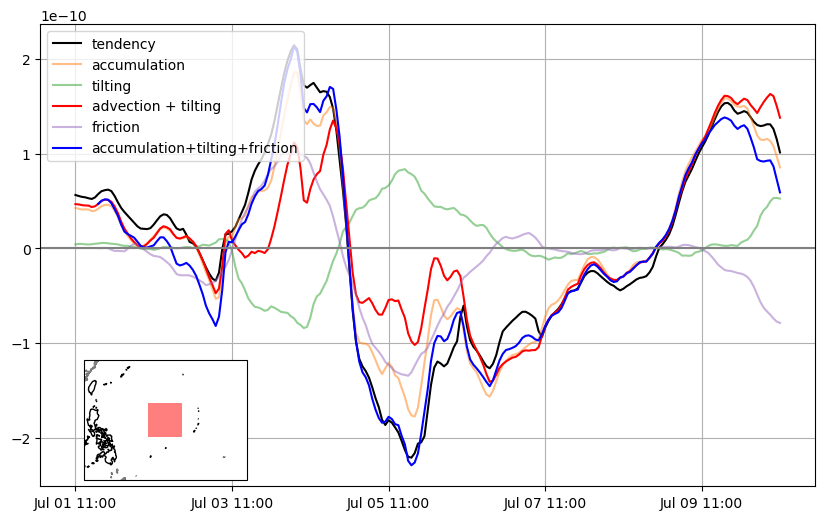

In [9]:
# Time stuff
t = np.arange(len(adv) - 24)
# remove points at end due to 24-point smoothing
times = pd.to_datetime(adv.time.values)[11:-12]
plot_times = times.strftime('%b %d %H:%M')
t = adv.time[11:-12]


fig = plt.figure(figsize=(10,6))
plt.plot(t, dav_dt_smooth, label = 'tendency', color = 'k')
plt.plot(t, -flux_div_smooth, label = 'accumulation', color = 'tab:orange', alpha=0.5)
plt.plot(t, -tilt_smooth, label = 'tilting', color = 'tab:green', alpha=0.5)
plt.plot(t, -flux_div_smooth - tilt_smooth, label = 'advection + tilting', color = 'r')
if calc_fric:
    t2 = fric.time[11:-12]
    plt.plot(t2, -fric_smooth, label = 'friction', color = 'tab:purple', alpha=0.5)
    plt.plot(t2, -flux_div_smooth-tilt_smooth-fric_smooth, label='accumulation+tilting+friction', color='b')
    
plt.axhline(color = 'grey')
#plt.ylim((-2e-10,2e-10))
plt.xticks(t.values[::48], plot_times[::48])
plt.legend(loc='upper left')
plt.grid()

# create map inset
axins = fig.add_axes([0.15, 0.12, 0.2, 0.2], transform=plt.gca().transAxes, projection=ccrs.PlateCarree())
axins.coastlines()
axins.add_feature(cfeature.STATES, edgecolor='gray')
axins.set_extent((min_lon - 15, max_lon + 15, min_lat - 10, max_lat + 10), crs=ccrs.PlateCarree())
# Shade box on map inset
lats = [min_lat,max_lat,max_lat,min_lat]
lons = [min_lon,min_lon,max_lon,max_lon]
xy = np.array([[min_lon, min_lat], [max_lon, min_lat], [max_lon, max_lat], [min_lon, max_lat]])
poly = Polygon(xy, facecolor='red', alpha=0.5)
plt.gca().add_patch(poly)

The below code looks at the vorticity fluxes (from each of the 3 components) through the boundary of the box.

In [10]:
%%time
if calc_fric:
    Z_x, Z_y, adv_x, adv_y, tilt_x, tilt_y, fric_x, fric_y = absolute_vorticity_flux(u, v, w, rv, fric=True, u_tend=u_tend, v_tend=v_tend)
    Z_x, Z_y, adv_x, adv_y, tilt_x, tilt_y, fric_x, fric_y = dask.compute(Z_x, Z_y, adv_x, adv_y, tilt_x, tilt_y, fric_x, fric_y)
else:
    Z_x, Z_y, adv_x, adv_y, tilt_x, tilt_y, _, _ = absolute_vorticity_flux(u, v, w, rv)
    Z_x, Z_y, adv_x, adv_y, tilt_x, tilt_y = dask.compute(Z_x, Z_y, adv_x, adv_y, tilt_x, tilt_y)

Z_x

CPU times: user 79.6 ms, sys: 23.3 ms, total: 103 ms
Wall time: 96.9 ms


<xarray.DataArray (time: 233, level: 3, latitude: 33, longitude: 33)>
array([[[[-3.56024628e-04, -3.78205236e-04, -3.79295302e-04, ...,
          -4.83380241e-04, -4.66898102e-04, -4.29708762e-04],
         [-3.60994032e-04, -3.62612205e-04, -3.58876089e-04, ...,
          -5.56563779e-04, -5.01974999e-04, -4.56650941e-04],
         [-3.88581437e-04, -3.11535100e-04, -3.30803687e-04, ...,
          -6.26491488e-04, -5.64525650e-04, -5.14804336e-04],
         ...,
         [-1.68140716e-04, -1.63632707e-04, -1.62234341e-04, ...,
          -1.25679536e-04, -1.17934671e-04, -1.11693382e-04],
         [-1.53512938e-04, -1.45923607e-04, -1.42468415e-04, ...,
          -1.27389086e-04, -1.21976873e-04, -1.23493869e-04],
         [-1.37862484e-04, -1.35999386e-04, -1.43034752e-04, ...,
          -1.21072691e-04, -1.10324278e-04, -1.15870308e-04]],

        [[-2.84930136e-04, -3.09850421e-04, -3.14161345e-04, ...,
          -7.37034829e-04, -7.87190266e-04, -7.71306542e-04],
         [-2.69062047e-04, -2.98397339e-04, -3.07423845e-04, ...,
          -7.79342479e-04, -7.89309672e-04, -7.39729455e-04],
         [-2.94586626e-04, -2.77936397e-04, -2.81682345e-04, ...,
          -6.66537683e-04, -6.29658574e-04, -6.05083392e-04],
...
         [-7.81063999e-05, -9.28096772e-05, -1.15031219e-04, ...,
          -1.41477926e-04, -1.02355620e-04, -1.09712628e-04],
         [-6.80448503e-05, -1.05537190e-04, -7.73121643e-05, ...,
          -2.23466064e-04, -1.57478131e-04, -1.36066747e-04],
         [-6.09472179e-05, -9.33664338e-05, -6.96600397e-05, ...,
          -2.67281755e-04, -2.02864100e-04, -1.46596186e-04]],

        [[-2.29405483e-04, -2.68348408e-04, -2.83773494e-04, ...,
          -1.39917142e-04, -2.02477976e-04, -2.25192051e-04],
         [-2.66773367e-04, -2.86932986e-04, -2.86310213e-04, ...,
          -1.41126547e-04, -2.08301065e-04, -2.53948028e-04],
         [-3.01841456e-04, -2.90123891e-04, -2.89310392e-04, ...,
          -1.45351672e-04, -2.53483094e-04, -3.06880804e-04],
         ...,
         [-3.73816511e-05, -1.36521680e-05, -5.82552091e-06, ...,
          -8.72515035e-05, -1.10439990e-04, -9.07599157e-05],
         [-2.92541772e-05, -2.45687400e-05,  3.18198181e-06, ...,
          -6.97207306e-05, -7.06037021e-05, -6.72001259e-05],
         [-2.47687811e-05, -4.03773264e-06, -3.63547587e-06, ...,
          -3.20136882e-05, -4.32115420e-05, -3.75818751e-05]]]])
Coordinates:
  * longitude  (longitude) float32 134.0 134.2 134.5 134.8 ... 141.5 141.8 142.0
  * latitude   (latitude) float32 20.0 19.75 19.5 19.25 ... 12.5 12.25 12.0
  * level      (level) int32 650 700 750
  * time       (time) datetime64[ns] 2016-07-01T07:00:00 ... 2016-07-10T23:00:00
    lonrad     (longitude) float32 2.339 2.343 2.347 2.352 ... 2.47 2.474 2.478
    latrad     (latitude) float32 0.3491 0.3447 0.3403 ... 0.2182 0.2138 0.2094

In [11]:
total_flux, flux_south, flux_east, flux_north, flux_west = boundary_flux(Z_x, Z_y, column_integrate=column_integrate)
total_adv, adv_south, adv_east, adv_north, adv_west = boundary_flux(adv_x, adv_y, column_integrate=column_integrate)
total_tilt, tilt_south, tilt_east, tilt_north, tilt_west = boundary_flux(tilt_x, tilt_y, column_integrate=column_integrate)
if calc_fric:
    total_fric, fric_south, fric_east, fric_north, fric_west = boundary_flux(fric_x, fric_y, column_integrate=column_integrate)

total_flux

<xarray.DataArray (time: 233, level: 3)>
array([[-2.34029073e-11,  7.58977761e-11, -2.25451543e-11],
       [-1.24488209e-11,  7.78969893e-11, -2.81796147e-12],
       [-3.49799103e-11,  7.53268973e-11,  2.88600857e-11],
       [ 4.51216478e-11,  1.29701477e-10,  8.45770980e-11],
       [ 5.21455429e-11,  1.42074559e-10,  1.08492126e-10],
       [ 1.19571170e-10,  1.58123556e-10,  1.27335367e-10],
       [ 1.81736365e-10,  1.77697021e-10,  1.31765041e-10],
       [ 1.54623605e-10,  1.04755289e-10,  3.85102551e-11],
       [ 1.40878032e-10,  3.47337727e-11,  1.41078528e-11],
       [ 1.65904152e-10, -3.35420112e-12,  1.71319846e-11],
       [ 1.32110964e-10,  7.97193466e-12,  1.59437958e-11],
       [ 1.05356790e-10,  4.48658185e-11,  2.37572026e-11],
       [ 1.08458394e-10,  4.00749656e-11, -3.82507341e-11],
       [ 1.07230273e-10,  1.94564074e-11, -3.74928744e-11],
       [ 8.24914867e-11, -2.69243174e-11, -4.54699740e-11],
       [ 6.17848998e-11, -7.62708894e-11, -5.58498567e-11],
       [ 3.41006109e-11, -5.24082725e-11,  6.77077866e-12],
       [-3.46951511e-11, -6.75240842e-11,  3.38436150e-11],
       [-8.64373681e-11, -4.36396820e-11,  8.61752639e-11],
       [-1.33753496e-10, -8.87428644e-12,  1.07680223e-10],
...
       [ 1.37605151e-10,  1.41346757e-10,  1.22434331e-10],
       [ 1.53521545e-10,  1.21270748e-10,  6.78105757e-11],
       [ 6.31881264e-11,  8.24966800e-11, -4.31209578e-12],
       [-5.35409000e-11,  4.72751150e-11,  2.87027887e-11],
       [-2.62554220e-11,  5.55296723e-11,  5.67994574e-12],
       [-3.53274219e-11,  1.13518435e-11, -4.58567012e-11],
       [ 4.17693425e-11,  3.98176363e-11, -1.83880401e-11],
       [ 2.11053110e-10,  1.53542540e-10,  1.03859312e-10],
       [ 1.63258129e-10,  1.47376324e-10,  1.91095104e-10],
       [ 5.80899101e-12,  6.17091061e-11,  1.51872171e-10],
       [-5.38888497e-11, -4.54759016e-11,  1.19743610e-10],
       [-1.15797887e-10, -5.79568561e-11,  2.23191129e-10],
       [-2.08852185e-10, -6.12145954e-11,  2.08317159e-10],
       [ 5.94210238e-11,  1.15003775e-10,  2.36528184e-10],
       [ 1.56352012e-10,  1.50968604e-10,  1.18127958e-10],
       [ 1.25138735e-10,  1.14497879e-10,  7.26029188e-11],
       [ 2.05980880e-10,  8.62214796e-11,  8.07393564e-11],
       [ 1.31013055e-10,  1.32868238e-11, -3.61265038e-12],
       [-5.78339756e-11, -1.69274989e-10, -2.12587489e-10],
       [-1.25721810e-10, -1.76635328e-10, -1.97018083e-10]])
Coordinates:
  * level    (level) int32 650 700 750
  * time     (time) datetime64[ns] 2016-07-01T07:00:00 ... 2016-07-10T23:00:00

In [12]:
total_flux_smooth = moving_average(total_flux)
flux_south_smooth = moving_average(flux_south)
flux_east_smooth = moving_average(flux_east)
flux_north_smooth = moving_average(flux_north)
flux_west_smooth = moving_average(flux_west)

total_adv_smooth = moving_average(total_adv)
adv_south_smooth = moving_average(adv_south)
adv_east_smooth = moving_average(adv_east)
adv_north_smooth = moving_average(adv_north)
adv_west_smooth = moving_average(adv_west)

total_tilt_smooth = moving_average(total_tilt)
tilt_south_smooth = moving_average(tilt_south)
tilt_east_smooth = moving_average(tilt_east)
tilt_north_smooth = moving_average(tilt_north)
tilt_west_smooth = moving_average(tilt_west)

if calc_fric:
    total_fric_smooth = moving_average(total_fric)
    fric_south_smooth = moving_average(fric_south)
    fric_east_smooth = moving_average(fric_east)
    fric_north_smooth = moving_average(fric_north)
    fric_west_smooth = moving_average(fric_west)

if not column_integrate:
    total_flux_smooth = total_flux_smooth.sel(level=p)
    flux_south_smooth = flux_south_smooth.sel(level=p)
    flux_east_smooth = flux_east_smooth.sel(level=p)
    flux_north_smooth = flux_north_smooth.sel(level=p)
    flux_west_smooth = flux_west_smooth.sel(level=p)

    total_adv_smooth = total_adv_smooth.sel(level=p)
    adv_south_smooth = adv_south_smooth.sel(level=p)
    adv_east_smooth = adv_east_smooth.sel(level=p)
    adv_north_smooth = adv_north_smooth.sel(level=p)
    adv_west_smooth = adv_west_smooth.sel(level=p)

    total_tilt_smooth = total_tilt_smooth.sel(level=p)
    tilt_south_smooth = tilt_south_smooth.sel(level=p)
    tilt_east_smooth = tilt_east_smooth.sel(level=p)
    tilt_north_smooth = tilt_north_smooth.sel(level=p)
    tilt_west_smooth = tilt_west_smooth.sel(level=p)

    if calc_fric:
        total_fric_smooth = total_fric_smooth.sel(level=p)
        fric_south_smooth = fric_south_smooth.sel(level=p)
        fric_east_smooth = fric_east_smooth.sel(level=p)
        fric_north_smooth = fric_north_smooth.sel(level=p)
        fric_west_smooth = fric_west_smooth.sel(level=p)

thin solid = accumulation

dashed = tilting

dotted = friction

thick solid = sum of all three

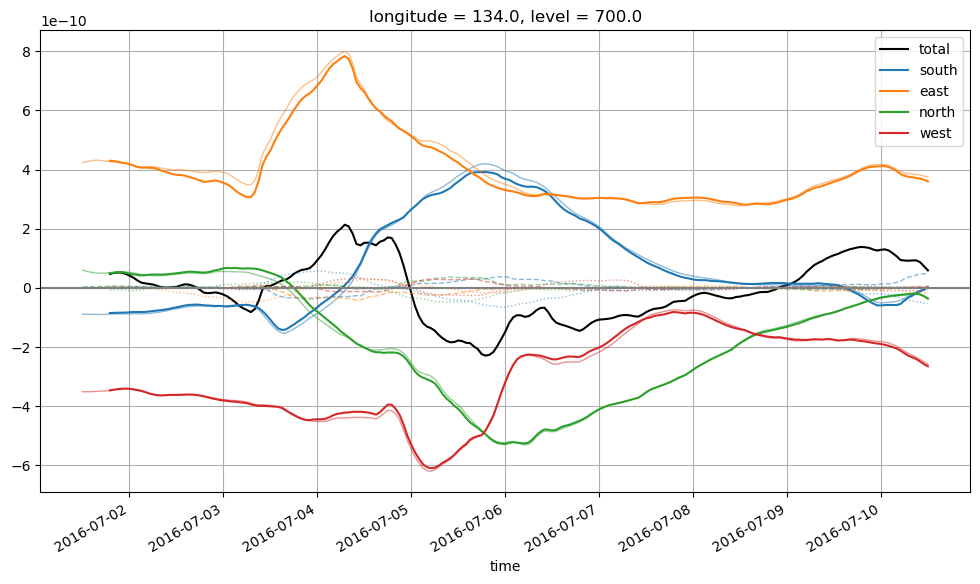

In [13]:
plt.figure(figsize=(12, 6))

total_flux_smooth.plot(label='total', color='k')

flux_south_smooth.plot(label='south', color='tab:blue')
adv_south_smooth.plot(color='tab:blue', linestyle='-', alpha=0.5, linewidth=1)
tilt_south_smooth.plot(color='tab:blue', linestyle='--', alpha=0.5, linewidth=1)

flux_east_smooth.plot(color='tab:orange', label='east')
adv_east_smooth.plot(color='tab:orange', linestyle='-', alpha=0.5, linewidth=1)
tilt_east_smooth.plot(color='tab:orange', linestyle='--', alpha=0.5, linewidth=1)

flux_north_smooth.plot(color='tab:green', label='north')
adv_north_smooth.plot(color='tab:green', linestyle='-', alpha=0.5, linewidth=1)
tilt_north_smooth.plot(color='tab:green', linestyle='--', alpha=0.5, linewidth=1)

flux_west_smooth.plot(color='tab:red', label='west')
adv_west_smooth.plot(color='tab:red', linestyle='-', alpha=0.5, linewidth=1)
tilt_west_smooth.plot(color='tab:red', linestyle='--', alpha=0.5, linewidth=1)

if calc_fric:
    fric_south_smooth.plot(color='tab:blue', linestyle=':', alpha=0.5, linewidth=1)
    fric_east_smooth.plot(color='tab:orange', linestyle=':', alpha=0.5, linewidth=1)
    fric_north_smooth.plot(color='tab:green', linestyle=':', alpha=0.5, linewidth=1)
    fric_west_smooth.plot(color='tab:red', linestyle=':', alpha=0.5, linewidth=1)


plt.grid()
plt.axhline(color='grey')

plt.legend()